In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import tikzplotlib
set_config(display="text")  # displays text representation of estimators

## Preparation of the data for scikit-survival


In [2]:
def shorten_long_string(x):
    return x[:3] + ".." + x[-3:]
    
def load_data(num_samples=20000):
    # Load data
    data_fname = "../data/common_conditions_breed_data.csv"
    data = pd.read_csv(data_fname)
    data = data.sample(n=num_samples, random_state=1)
    # Prepare data for survival analysis:
    # 1. Choose only necessary columns
    # 2. Make sure columns have correct type
    # 3. Extract target data and format for scikit-survival

    # Shorten Abbatoir values
    data['Abbatoir'] = data['Abbatoir'].apply(shorten_long_string)
    # Rename columns
    data = data.rename(columns={'Abbatoir': 'Abattoir',
                                'Abattoir_._Died_on_Farm': 'DeathLoc', 
                                'Beef_or_Dairy': 'ProdType',
                               'AvgOftotal_animals': 'HerdSize',
                               'Dvo_Code': 'DVO',
                               'Total_Conditions_per_Animal': 'NumHealthCond'})
    
    # Firstly, extract the target data
    lifespan = data['days_alive']
    # and create an array of pairs
    lifespan = np.array([(True, days_alive_i) for days_alive_i in lifespan], dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
    
    # Next, choose columns and make some of them categorical
    categorical_columns = ['DVO', 'Breed', 'Sex', 'Abattoir', 'DeathLoc', 'ProdType']
    numerical_columns = ['NumHealthCond', 'HerdSize']
    descriptor_columns = categorical_columns + numerical_columns
    data = data[descriptor_columns]
    for col in categorical_columns:
        data[col] = data[[col]].apply(lambda x: x.astype('category'))
    Xt = OneHotEncoder().fit_transform(data)
    return Xt, lifespan

In [3]:
xdata, ydata = load_data(num_samples=50000)

## Regularised Cox Models

### Ridge regression

In [4]:
def plot_coefficients(coefs, n_highlight, tikz_file_name="images/vodya_ridge.tex"):
    _, ax = plt.subplots(figsize=(6, 4))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        alp = 1
        first_weight = np.abs(row[1])
        if first_weight < 0.7:
            alp = np.max([0.2, np.min([first_weight / 0.7, 1])])
        ax.semilogx(alphas, row[1:], ".-", label=row.Index, alpha=alp)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")
    if tikz_file_name is not None:
        tikzplotlib.save(tikz_file_name)
    

In [5]:
alphas = 10.0 ** np.linspace(-2, 6, 10)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(xdata, ydata)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(index="feature", columns="alpha").set_index(xdata.columns)

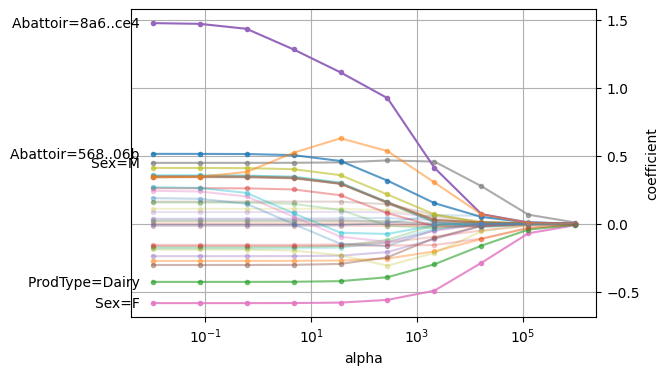

In [6]:
plot_coefficients(coefficients, n_highlight=5)

## Lasso

In [7]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[1e-4, 0.001, 0.01, 0.1, 0.2, 0.5, 1])
cox_elastic_net.fit(xdata, ydata)
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=xdata.columns, columns=np.round(cox_elastic_net.alphas_, 5)
)


In [ ]:
plot_coefficients(coefficients_elastic_net, n_highlight=7)

In [ ]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=1, alphas=[0.001])
cox_elastic_net.fit(xdata, ydata)  
cox_elastic_net.coef_

alp = 0.00000, Mean AUC: 0.807 	 Min AUC: 0.697
alp = 0.00000, Mean AUC: 0.807 	 Min AUC: 0.697
alp = 0.00050, Mean AUC: 0.807 	 Min AUC: 0.697
alp = 0.00100, Mean AUC: 0.807 	 Min AUC: 0.697
alp = 0.00500, Mean AUC: 0.804 	 Min AUC: 0.698
alp = 0.01000, Mean AUC: 0.803 	 Min AUC: 0.695
alp = 0.02000, Mean AUC: 0.797 	 Min AUC: 0.671
alp = 0.03000, Mean AUC: 0.782 	 Min AUC: 0.623
alp = 0.05000, Mean AUC: 0.770 	 Min AUC: 0.542
alp = 0.10000, Mean AUC: 0.760 	 Min AUC: 0.542


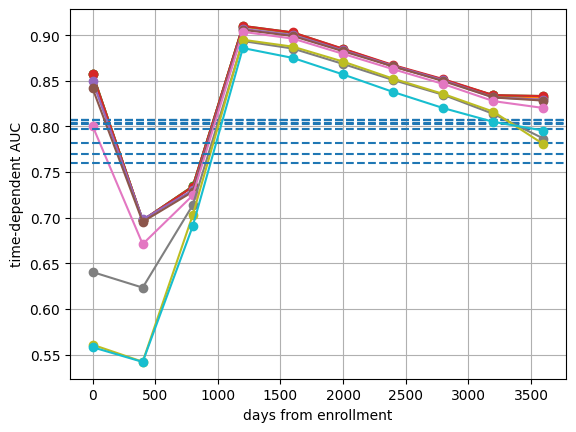

In [45]:
from sksurv.metrics import cumulative_dynamic_auc
xtest, ytest = load_data(num_samples=20000)

for alp in [1e-12, 1e-10, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]:
    cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.8, alphas=[alp])
    cox_elastic_net.fit(xdata, ydata)    
    va_times = np.linspace(0.01, 3600, 10)
    cph_risk_scores = cox_elastic_net.predict(xtest)    
    cph_auc, cph_mean_auc = cumulative_dynamic_auc(ydata, ytest, cph_risk_scores, va_times)
    print("alp = {:.5f}, Mean AUC: {:.3f} \t Min AUC: {:.3f}".format(alp, cph_mean_auc, np.min(cph_auc)))

    plt.plot(va_times, cph_auc, marker="o")
    plt.axhline(cph_mean_auc, linestyle="--")
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.grid(True)


In [47]:
cox_elastic_net.coef_

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-3.83043747e-01],
       [ 2.67518806e-01],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-9.88774898e-02],
       [-7.01078137e-03],
       [-5.28787818e-05]])

## Choosing alpha with cross-validation


In [9]:
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [10]:
coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1, alpha_min_ratio=0.0001, max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(xdata, ydata)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.0001, l1_ratio=1,
                                        max_iter=100))])

In [ ]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(xdata, ydata)

cv_results = pd.DataFrame(gcv.cv_results_)

In [ ]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

## Endnotes

In [4]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
data_fname = "../data/common_conditions_breed_data.csv"
data = pd.read_csv(data_fname)

In [5]:
data.columns

Index(['Herd_Id', 'Year', 'Dvo_Code', 'Month', 'Animal_Id', 'Abbatoir',
       'Breed', 'Sex', 'Dob', 'Dod', 'Abattoir_._Died_on_Farm',
       'Beef_or_Dairy', 'Total_Conditions_per_Animal', 'status', 'days_alive',
       'months_alive', 'years_alive', 'T_2M', 'RH2M', 'AvgOftotal_animals',
       'No', 'PLEUR.PNEUMONIA.LOCAL', 'OEDEMA', 'NEPHRITIS', 'NAD',
       'CONTAMINATION', 'TB.GENERALISED', 'TB', 'ABSCESS.PYAEMIA',
       'FLUKE.DAMAGE', 'HYDRONEPHROSIS', 'PLEUR.PNEUMONIA.GENERAL',
       'PETECHAE.HAEMORRHAGES', 'INJECTION.SITES', 'PERITONITIS', 'PLEURISY',
       'FACTORY.DAMAGE', 'PERICARDITIS', 'BRUISING', 'SCAR.TISSUE',
       'TELANGECTASIS', 'RESIDUES', 'ARTHRITIS', 'FASCIOLIASIS', 'ACTINO'],
      dtype='object')

In [108]:
data.shape

(1832677, 45)

In [9]:
def tikzplotlib_fix_ncols(obj):
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

8a60fb1b9b40ed0fdc5d3c061e9388972f3bdce4 :: 60110
94003c4910d6c601a698a3258918fc822b88dd0d :: 152901
f833f5d69610136a115182502764c803be97ee16 :: 59386
4f71277e271f09349a4d6d5f6c05acf635652015 :: 222504
ae2f3299f13dc08c27a4bd4586901243017aa1c0 :: 196793
7a032bbcfa7447fb21edc6e6f8d7bab0bed1bb16 :: 21203
32d8a591f643abd1ff6a998b128403c8962a55d8 :: 77134
332a6a1d2843f367c160a1c7c3fb2a28f0f8909e :: 182008
ba747dbffafe62fb8bea541fd72df6d8c7afcb2f :: 50772
9032d4760ad9a99eb868b5d854cbae1492401dda :: 208390
87fc1df58026b8a228f9c4afa002b2b7722a8f09 :: 172480
6f7d51dd8564e05e279faa791f97894ef141a4db :: 180305
568a97a7e2a6685902dd553c276b1837e0ebf06b :: 230036
cdf0a11f70869c640bfe6c23935ff3da4acfb7b0 :: 18651
432d3a852c6074754d640e8d1369a1c56b0d5805 :: 3
52d480596328cca7948b6f1f31e1f2b18590cf10 :: 1


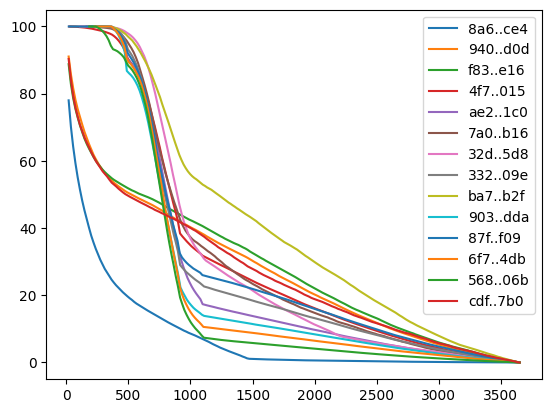

In [6]:
       
fig = plt.figure()
abatts = data["Abbatoir"].unique()
for ab in abatts:
    dat = data.loc[data["Abbatoir"] == ab]
    print(f"{ab} :: {dat.shape[0]}")
    if dat.shape[0] > 1000:        
        pdf, bin_edges = np.histogram(
           dat["days_alive"], # array of data
           bins=200,    # specify the number of bins for distribution function
           density=True # True to return probability density function (pdf) instead of count
           )
        cdf = np.cumsum(pdf*np.diff(bin_edges))
        plt.plot(bin_edges[1:], 100*(1-cdf), label=ab[:3]+".."+ab[-3:])

plt.legend()
tikzplotlib_fix_ncols(fig)

# plt.show()

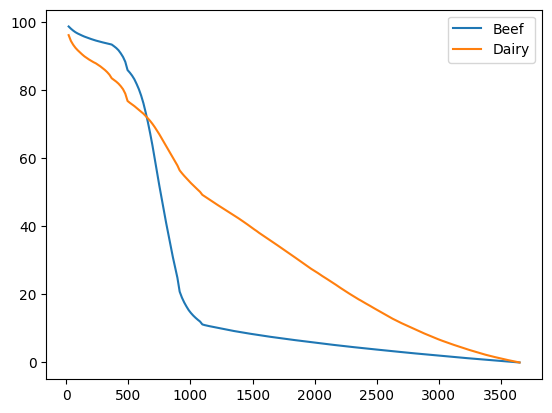

In [5]:
fig = plt.figure()
for prod_type in data["Beef_or_Dairy"].unique():
    dat = data.loc[data["Beef_or_Dairy"] == prod_type]
    pdf, bin_edges = np.histogram(
           dat["days_alive"], # array of data
           bins=200,    # specify the number of bins for distribution function
           density=True # True to return probability density function (pdf) instead of count
           )
    cdf = np.cumsum(pdf*np.diff(bin_edges))
    plt.plot(bin_edges[1:], 100*(1-cdf), label=prod_type)

plt.legend()
tikzplotlib_fix_ncols(fig)
tikzplotlib.save("./images/beef_dairy.tex")

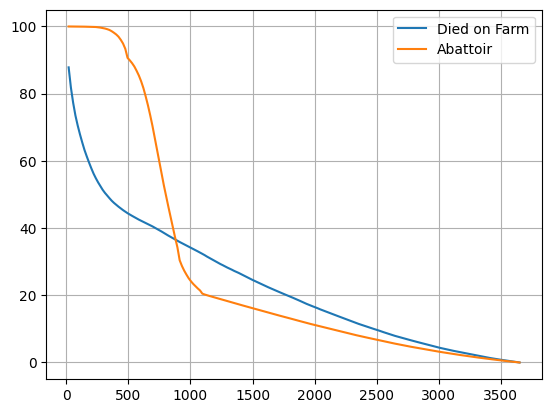

In [16]:
fig2 = plt.figure()
for v in data["Abattoir_._Died_on_Farm"].unique():
    dat = data.loc[data["Abattoir_._Died_on_Farm"] == v]
    pdf, bin_edges = np.histogram(
           dat["days_alive"], # array of data
           bins=200,    # specify the number of bins for distribution function
           density=True # True to return probability density function (pdf) instead of count
           )
    cdf = np.cumsum(pdf*np.diff(bin_edges))
    plt.plot(bin_edges[1:], 100*(1-cdf), label=v)

plt.legend()
plt.grid()
tikzplotlib_fix_ncols(fig2)
tikzplotlib.save("./images/place_of_death.tex")

In [34]:
dat = data.loc[data["Abattoir_._Died_on_Farm"] == "Died on Farm"]
pdf1, bin_edges1 = np.histogram(
           dat["days_alive"], # array of data
           bins=200,    # specify the number of bins for distribution function
           density=True # True to return probability density function (pdf) instead of count
           )
cdf1 = np.cumsum(pdf1*np.diff(bin_edges1))
dat = data.loc[data["Abattoir_._Died_on_Farm"] == "Abattoir"]
pdf2, bin_edges2 = np.histogram(
           dat["days_alive"], # array of data
           bins=200,    # specify the number of bins for distribution function
           density=True # True to return probability density function (pdf) instead of count
           )
cdf2 = np.cumsum(pdf2*np.diff(bin_edges2))

df = cdf1 - cdf2
np.where(np.abs(df) < 0.01)
bin_edges2[47]

858.22

LIM :: 377016
HER :: 110212
SIM :: 98312
AA :: 297099
CH :: 324898
HOL :: 188133
BB :: 88221
FR :: 348786


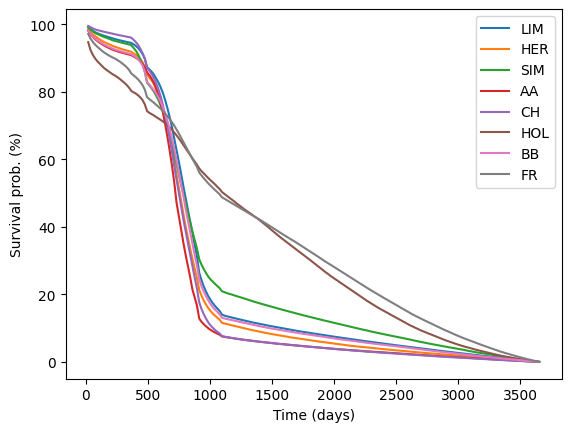

In [12]:
fig = plt.figure()
abatts = data["Breed"].unique()
for br in abatts:
    dat = data.loc[data["Breed"] == br]
    print(f"{br} :: {dat.shape[0]}")
    if dat.shape[0] > 1000:        
        pdf, bin_edges = np.histogram(
           dat["days_alive"], # array of data
           bins=200,    # specify the number of bins for distribution function
           density=True # True to return probability density function (pdf) instead of count
           )
        cdf = np.cumsum(pdf*np.diff(bin_edges))
        plt.plot(bin_edges[1:], 100*(1-cdf), label=br)

plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Survival prob. (%)")
tikzplotlib_fix_ncols(fig)
tikzplotlib.save("./images/breed.tex")

NAD :: 11072 ; median: 784.0
FLUKE.DAMAGE :: 76376 ; median: 874.0
HYDRONEPHROSIS :: 1226 ; median: 901.0
FASCIOLIASIS :: 32605 ; median: 841.0
ACTINO :: 1273 ; median: 847.0
PERITONITIS :: 6661 ; median: 1022.0
TELANGECTASIS :: 2894 ; median: 2523.0
OEDEMA :: 676 ; median: 2335.0
INJECTION.SITES :: 1331 ; median: 773.0


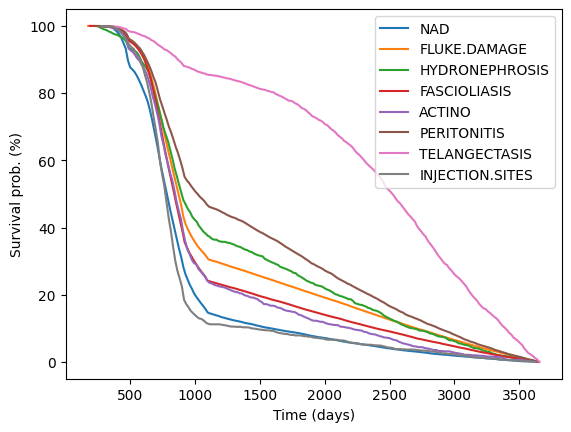

In [34]:
fig = plt.figure()

for cond in ['NAD', 'FLUKE.DAMAGE', 'HYDRONEPHROSIS', 'FASCIOLIASIS', 'ACTINO', 'PERITONITIS', 'TELANGECTASIS', 'OEDEMA', 'INJECTION.SITES']:
    dat = data.loc[(data[cond] == 1) & (data["Total_Conditions_per_Animal"] == 1)]
    md = np.median(dat["days_alive"].to_numpy())
    print(f"{cond} :: {dat.shape[0]} ; median: {md}")
    if dat.shape[0] > 1000:        
        pdf, bin_edges = np.histogram(
           dat["days_alive"], # array of data
           bins=200,    # specify the number of bins for distribution function
           density=True # True to return probability density function (pdf) instead of count
           )
        cdf = np.cumsum(pdf*np.diff(bin_edges))
        plt.plot(bin_edges[1:], 100*(1-cdf), label=cond)

plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Survival prob. (%)")
tikzplotlib_fix_ncols(fig)
tikzplotlib.save("./images/health_conditions.tex")

PLEUR.PNEUMONIA.LOCAL :: 15431
OEDEMA :: 3729
NEPHRITIS :: 6129
NAD :: 13287
CONTAMINATION :: 82797
TB.GENERALISED :: 3566
TB :: 28530
ABSCESS.PYAEMIA :: 35622
FLUKE.DAMAGE :: 100398
HYDRONEPHROSIS :: 3806
PLEUR.PNEUMONIA.GENERAL :: 8078
PETECHAE.HAEMORRHAGES :: 3287
INJECTION.SITES :: 2220
PERITONITIS :: 15763
PLEURISY :: 4476
FACTORY.DAMAGE :: 10352
PERICARDITIS :: 7118
BRUISING :: 13298
SCAR.TISSUE :: 2568
TELANGECTASIS :: 6257
RESIDUES :: 5036
ARTHRITIS :: 1952
FASCIOLIASIS :: 40958
ACTINO :: 1928


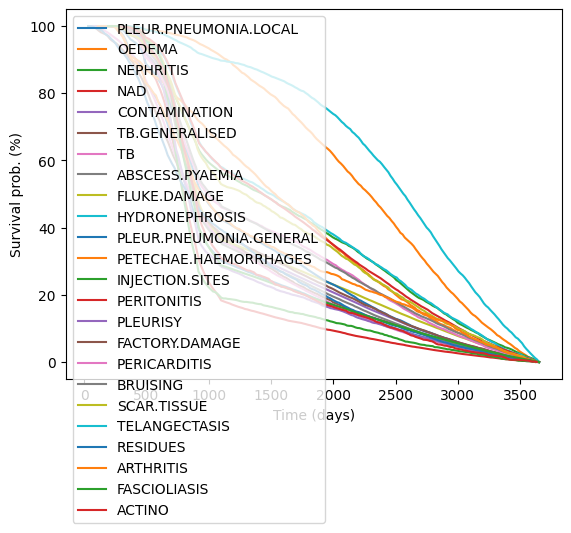

In [23]:
fig = plt.figure()

for cond in ['PLEUR.PNEUMONIA.LOCAL', 'OEDEMA', 'NEPHRITIS', 'NAD',
       'CONTAMINATION', 'TB.GENERALISED', 'TB', 'ABSCESS.PYAEMIA',
       'FLUKE.DAMAGE', 'HYDRONEPHROSIS', 'PLEUR.PNEUMONIA.GENERAL',
       'PETECHAE.HAEMORRHAGES', 'INJECTION.SITES', 'PERITONITIS', 'PLEURISY',
       'FACTORY.DAMAGE', 'PERICARDITIS', 'BRUISING', 'SCAR.TISSUE',
       'TELANGECTASIS', 'RESIDUES', 'ARTHRITIS', 'FASCIOLIASIS', 'ACTINO']:

    dat = data.loc[data[cond] == 1]
    print(f"{cond} :: {dat.shape[0]}")
    if dat.shape[0] > 1000:        
        pdf, bin_edges = np.histogram(
           dat["days_alive"], # array of data
           bins=200,    # specify the number of bins for distribution function
           density=True # True to return probability density function (pdf) instead of count
           )
        cdf = np.cumsum(pdf*np.diff(bin_edges))
        plt.plot(bin_edges[1:], 100*(1-cdf), label=cond)

plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Survival prob. (%)")
tikzplotlib_fix_ncols(fig)
tikzplotlib.save("./images/breed.tex")

In [47]:
print(data.columns)
data.loc[(data["Abattoir_._Died_on_Farm"] == "Died on Farm") & (data["Sex"]=="M")].shape[0]

#data.loc[(data[cond] == 1) & (data["Total_Conditions_per_Animal"] == 1)]

Index(['Herd_Id', 'Year', 'Dvo_Code', 'Month', 'Animal_Id', 'Abbatoir',
       'Breed', 'Sex', 'Dob', 'Dod', 'Abattoir_._Died_on_Farm',
       'Beef_or_Dairy', 'Total_Conditions_per_Animal', 'status', 'days_alive',
       'months_alive', 'years_alive', 'T_2M', 'RH2M', 'AvgOftotal_animals',
       'No', 'PLEUR.PNEUMONIA.LOCAL', 'OEDEMA', 'NEPHRITIS', 'NAD',
       'CONTAMINATION', 'TB.GENERALISED', 'TB', 'ABSCESS.PYAEMIA',
       'FLUKE.DAMAGE', 'HYDRONEPHROSIS', 'PLEUR.PNEUMONIA.GENERAL',
       'PETECHAE.HAEMORRHAGES', 'INJECTION.SITES', 'PERITONITIS', 'PLEURISY',
       'FACTORY.DAMAGE', 'PERICARDITIS', 'BRUISING', 'SCAR.TISSUE',
       'TELANGECTASIS', 'RESIDUES', 'ARTHRITIS', 'FASCIOLIASIS', 'ACTINO'],
      dtype='object')


94572

In [52]:
fig = plt.figure()
abatts = data["Abbatoir"].unique()
for ab in abatts:
    dat = data.loc[data["Abbatoir"] == ab]
    ni = dat.shape[0]
    nb = dat.loc[dat["Beef_or_Dairy"]=="Beef"].shape[0]
    nd = dat.loc[dat["Beef_or_Dairy"]=="Dairy"].shape[0]
    print(f"{ab} {ni} -- beef/dairy: {nb/nd}")

8a60fb1b9b40ed0fdc5d3c061e9388972f3bdce4 60110 -- beef/dairy: 1.0626587056482053
94003c4910d6c601a698a3258918fc822b88dd0d 152901 -- beef/dairy: 0.6191651135208404
f833f5d69610136a115182502764c803be97ee16 59386 -- beef/dairy: 0.5661691017458726
4f71277e271f09349a4d6d5f6c05acf635652015 222504 -- beef/dairy: 1.6082430721620482
ae2f3299f13dc08c27a4bd4586901243017aa1c0 196793 -- beef/dairy: 3.008167338791804
7a032bbcfa7447fb21edc6e6f8d7bab0bed1bb16 21203 -- beef/dairy: 34.5755033557047
32d8a591f643abd1ff6a998b128403c8962a55d8 77134 -- beef/dairy: 21.686470588235295
332a6a1d2843f367c160a1c7c3fb2a28f0f8909e 182008 -- beef/dairy: 2.17524118560388
ba747dbffafe62fb8bea541fd72df6d8c7afcb2f 50772 -- beef/dairy: 9.178829190056135
9032d4760ad9a99eb868b5d854cbae1492401dda 208390 -- beef/dairy: 4.340457702262884
87fc1df58026b8a228f9c4afa002b2b7722a8f09 172480 -- beef/dairy: 2.0460044150110375
6f7d51dd8564e05e279faa791f97894ef141a4db 180305 -- beef/dairy: 5.406971785942719
568a97a7e2a6685902dd553c276b1

<Figure size 640x480 with 0 Axes>